# Discrete Hedged Option Portfolio PnL
Actual vol > implied vol인 상황을 가정
* Actual vol로 hedge하는 경우
* implied vol로 hedge하는 경우

로 나누어 진행

**Table of contents**
1. [Package Import](###Package-Import)
2. [Hyperparameter Setting](###Hyperparameter-Setting)
3. [When sigma = imp_vol](##When-sigma-=-imp_vol)
    - [Figure 47.2](###Figure-47.2-i)
    - [Figure 47.3](###Figure-47.3-i)
    - [Figure 47.7](###Figure-47.7-i)
3. [When sigma = act_vol](##When-sigma-=-act_vol)
    - [Figure 47.2](###Figure-47.2-a)
    - [Figure 47.3](###Figure-47.3-a)
    - [Figure 47.7](###Figure-47.7-a)

### Package Import

In [158]:
import pandas as pd #dataframe
import matplotlib.pyplot as plt
import plotly.graph_objects as go #visualization 47.3, 47.7
import numpy as np #log, exp, ..
from scipy.stats import norm #정규분포난수 $phi$

### Hyperparameter-Setting

In [159]:
np.random.seed(42) #random seed

S = 100 #spot price
K = 100 #strike
#volatility
act_vol = 0.4
imp_vol = 0.2
R = 0.12 #return 
T = 1 #expiry
dt = 0.01 #timestep
rf = 0.05 #risk-free rate
div = 0 #dividend

phi = np.random.randn(int(T/dt)) #

## When sigma = imp_vol

In [160]:
sigma = imp_vol

### Figure 47.2 i
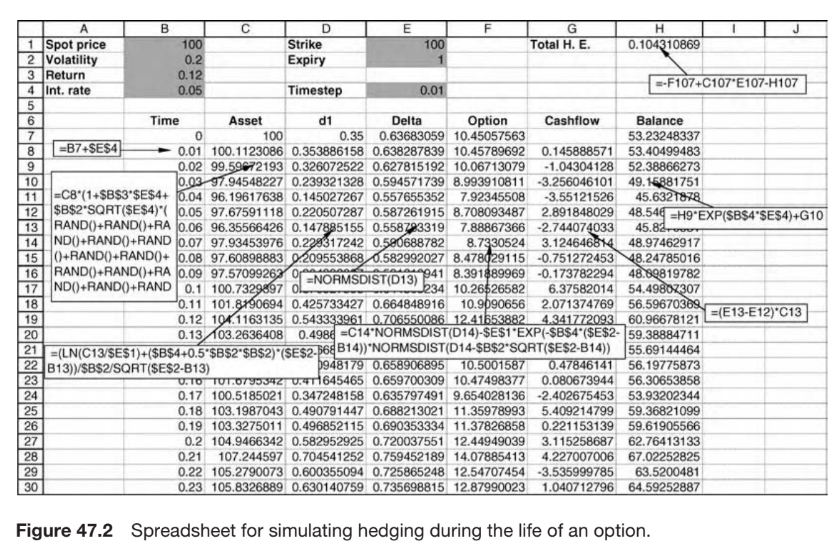

In [161]:
def Call_BSE(S, K, tau, r, q, sigma=sigma):
    N = norm.cdf
    if T == 0:
        return np.max(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * (tau)) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)
        return S * np.exp(-q * tau) * N(d1) - K * np.exp(-r * tau) * N(d2)
    
def Tau(table,index,T=T) :
    return T-table.index[index]

def d1(table,index,K=K,rf=rf,div=div,sigma=sigma) :
    return (np.log(table.iloc[index,1] / K) + (rf - div + sigma ** 2 / 2) * table.iloc[index,0]) / (sigma * np.sqrt(table.iloc[index,0]))

In [162]:
table = pd.DataFrame(columns=['Tau','Asset','d1','Delta','Option','Cashflow','Balance','Hedge Error'],index=[i*dt for i in range(int(T/dt)+1)])
table = table.fillna(0)
N = norm.cdf
init_d1 = (np.log(S / K) + (rf - div + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
table.loc[0]=np.array([T,S,init_d1,N(init_d1),Call_BSE(S,K,T,rf,div),0,S*(1-init_d1)-Call_BSE(S,K,T,rf,div),0])

for i in range(0,int(T/dt)) :
    table.iloc[i+1,1] = table.iloc[i,1]*(1+R*dt+act_vol*np.sqrt(dt)*phi[i])
for i in range(0,int(T/dt)+1) :
    table.iloc[i,0] = Tau(table,i)
    table.iloc[i,2] = d1(table,i)
    table.iloc[i,3] = N(table.iloc[i,2])
    table.iloc[i,4] = Call_BSE(table.iloc[i,1],K,table.iloc[i,0],rf,div)
for i in range(0,int(T/dt)) :
    table.iloc[i+1,5] = (table.iloc[i+1,3] - table.iloc[i,3])*table.iloc[i+1,1]
table.iloc[0,6] = table.iloc[0,1]*(1-table.iloc[0,2])-table.iloc[0,4]
for i in range(0,int(T/dt)) :
    table.iloc[i+1,6] = (table.iloc[i,6])*np.exp(rf*dt)+table.iloc[i+1,5]
for i in range(0,int(T/dt)+1) :
    table.iloc[i,7] = (-table.iloc[i,4]+table.iloc[i,1]*table.iloc[i,3]-table.iloc[i,6])

display(table)
print(f"Total H. E. : {-table.loc[T,'Option']+table.loc[T,'Asset']*table.loc[T,'Delta']-table.loc[T,'Balance']}")

C:\Users\user\AppData\Local\Temp\ipykernel_28988\159576967.py:14: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\user\AppData\Local\Temp\ipykernel_28988\159576967.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



,Tau,Asset,d1,Delta,Option,Cashflow,Balance,Hedge Error
0.00,1.00,100.000000,0.350000,6.368307e-01,1.045058e+01,0.000000e+00,54.549416,-1.316935
0.01,0.99,102.106857,0.453019,6.747326e-01,1.176771e+01,3.870045e+00,58.446743,-1.319629
0.02,0.98,101.664676,0.429869,6.663545e-01,1.140568e+01,-8.517502e-01,57.624223,-1.285186
0.03,0.97,104.420555,0.564311,7.137287e-01,1.324208e+01,4.946839e+00,62.599882,-1.314011
0.04,0.96,110.907285,0.871224,8.081841e-01,1.812500e+01,1.047579e+01,73.106984,-1.598473
...,...,...,...,...,...,...,...,...
0.96,0.04,68.409527,-9.421452,2.224459e-21,6.296867e-22,-4.562579e-11,5.176308,-5.176308
0.97,0.03,69.301916,-10.525027,3.312127e-26,7.400386e-27,-1.541570e-19,5.178897,-5.178897
0.98,0.02,70.108744,-12.505985,3.461824e-36,5.409081e-37,-2.322090e-24,5.181487,-5.181487
0.99,0.01,70.207214,-17.650956,5.002447e-70,3.949898e-71,-2.430450e-34,5.184078,-5.184078


Total H. E. : -5.186670969471089


### Figure 47.3 i
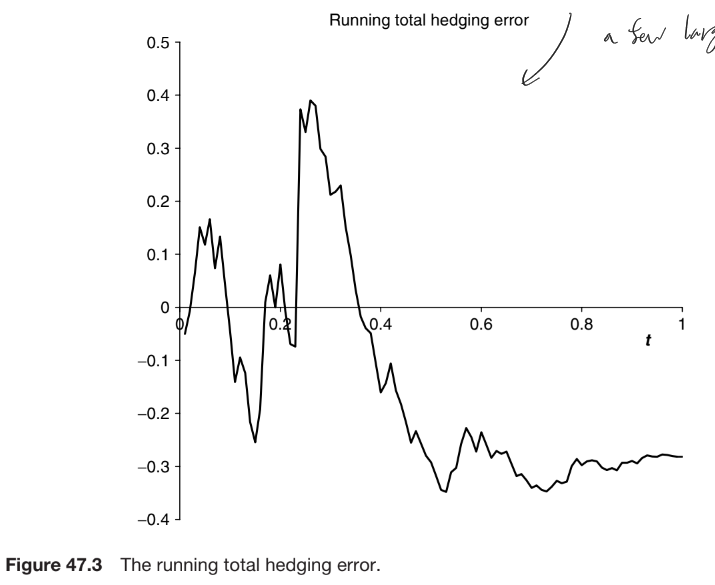

In [163]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=table.index, y=table['Hedge Error'], mode='lines+markers', name='P&L'))

fig.update_layout(
    title='The running total hedging error', 
    xaxis_title='Time', 
    yaxis=dict(
        title='P&L'
    )
)

fig.show()

### Figure 47.7 i
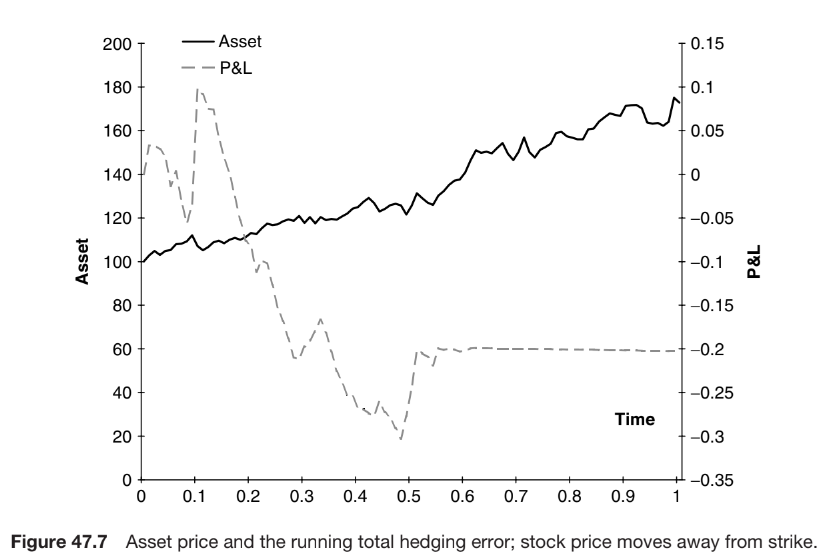

In [164]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=table.index, y=table['Asset'], mode='lines+markers', name='Asset', yaxis='y'))

fig.add_trace(go.Scatter(x=table.index, y=table['Hedge Error'], mode='lines+markers', name='P&L', yaxis='y2'))

fig.update_layout(
    title='Asset price and the running total hedging error', 
    xaxis_title='Time', 
    yaxis=dict(
        title = 'Asset'
    ),
    yaxis2=dict(
        title='P&L',
        overlaying = 'y',
        side = 'right'
    )
)

fig.show()

## When sigma=act_vol

In [165]:
sigma = act_vol

### Figure 47.2 a

In [166]:
def Call_BSE(S, K, tau, r, q, sigma=sigma):
    N = norm.cdf
    if T == 0:
        return np.max(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * (tau)) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)
        return S * np.exp(-q * tau) * N(d1) - K * np.exp(-r * tau) * N(d2)
    
def Tau(table,index,T=T) :
    return T-table.index[index]

def d1(table,index,K=K,rf=rf,div=div,sigma=sigma) :
    return (np.log(table.iloc[index,1] / K) + (rf - div + sigma ** 2 / 2) * table.iloc[index,0]) / (sigma * np.sqrt(table.iloc[index,0]))

In [167]:
table = pd.DataFrame(columns=['Tau','Asset','d1','Delta','Option','Cashflow','Balance','Hedge Error'],index=[i*dt for i in range(int(T/dt)+1)])
table = table.fillna(0)
N = norm.cdf
init_d1 = (np.log(S / K) + (rf - div + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
table.loc[0]=np.array([T,S,init_d1,N(init_d1),Call_BSE(S,K,T,rf,div),0,S*(1-init_d1)-Call_BSE(S,K,T,rf,div),0])

for i in range(0,int(T/dt)) :
    table.iloc[i+1,1] = table.iloc[i,1]*(1+R*dt+act_vol*np.sqrt(dt)*phi[i])
for i in range(0,int(T/dt)+1) :
    table.iloc[i,0] = Tau(table,i)
    table.iloc[i,2] = d1(table,i)
    table.iloc[i,3] = N(table.iloc[i,2])
    table.iloc[i,4] = Call_BSE(table.iloc[i,1],K,table.iloc[i,0],rf,div)
for i in range(0,int(T/dt)) :
    table.iloc[i+1,5] = (table.iloc[i+1,3] - table.iloc[i,3])*table.iloc[i+1,1]
table.iloc[0,6] = table.iloc[0,1]*(1-table.iloc[0,2])-table.iloc[0,4]
for i in range(0,int(T/dt)) :
    table.iloc[i+1,6] = (table.iloc[i,6])*np.exp(rf*dt)+table.iloc[i+1,5]
for i in range(0,int(T/dt)+1) :
    table.iloc[i,7] = (-table.iloc[i,4]+table.iloc[i,1]*table.iloc[i,3]-table.iloc[i,6])
display(table)
print(f"Total H. E. : {-table.loc[T,'Option']+table.loc[T,'Asset']*table.loc[T,'Delta']-table.loc[T,'Balance']}")

C:\Users\user\AppData\Local\Temp\ipykernel_28988\159576967.py:14: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\user\AppData\Local\Temp\ipykernel_28988\159576967.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



,Tau,Asset,d1,Delta,Option,Cashflow,Balance,Hedge Error
0.00,1.00,100.000000,0.325000,6.274095e-01,1.802295e+01,0.000000e+00,49.477049,-4.759054
0.01,0.99,102.106857,0.375758,6.464515e-01,1.926610e+01,1.944322e+00,51.446115,-4.705081
0.02,0.98,101.664676,0.363427,6.418570e-01,1.888148e+01,-4.670979e-01,51.004747,-4.632043
0.03,0.97,104.420555,0.429888,6.663616e-01,2.058358e+01,2.558779e+00,53.589035,-4.590771
0.04,0.96,110.907285,0.582582,7.199125e-01,2.498066e+01,5.939187e+00,59.555023,-4.692142
...,...,...,...,...,...,...,...,...
0.96,0.04,68.409527,-4.680726,1.429303e-06,1.521817e-06,-1.512432e-02,4.758933,-4.758837
0.97,0.03,69.301916,-5.236533,8.181064e-08,6.949796e-08,-9.338383e-05,4.761220,-4.761214
0.98,0.02,70.108744,-6.231779,2.305836e-10,1.388335e-10,-5.719475e-06,4.763595,-4.763595
0.99,0.01,70.207214,-8.810478,6.230679e-19,1.929390e-19,-1.618863e-08,4.765977,-4.765977


Total H. E. : -4.768361083316912


### Figure 47.3 a

In [168]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=table.index, y=table['Hedge Error'], mode='lines+markers', name='P&L'))

fig.update_layout(
    title='The running total hedging error', 
    xaxis_title='Time', 
    yaxis=dict(
        title='P&L'
    )
)

fig.show()

### Figure 47.7 a

In [169]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=table.index, y=table['Asset'], mode='lines+markers', name='Asset', yaxis='y'))

fig.add_trace(go.Scatter(x=table.index, y=table['Hedge Error'], mode='lines+markers', name='P&L', yaxis='y2'))

fig.update_layout(
    title='Asset price and the running total hedging error', 
    xaxis_title='Time', 
    yaxis=dict(
        title = 'Asset'
    ),
    yaxis2=dict(
        title='P&L',
        overlaying = 'y',
        side = 'right'
    )
)

fig.show()